In [1]:
import numpy as np

Import the dataset downloaded from source:

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
#List of train data files:
data_batches = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5',]
#Unpickling every batch in the list:
train_data_dicts = [unpickle(batch) for batch in data_batches]
#Unpickling test data file:
test_data_dict = unpickle('test_batch')
#Unpickling label names file:
label_names_dicts = unpickle('batches.meta')
label_names = [str(label, 'utf-8') for label in label_names_dicts[b'label_names']]

In [4]:
#Group batches and define train data:
x_train = np.empty(shape=(0,3072),dtype=np.uint8)
y_train = []
for dict in train_data_dicts:
    x_train = np.append(x_train, dict[b'data'], axis = 0)
    y_train += dict[b'labels']
y_train = np.asarray(y_train)

#Define test data:
x_test = np.array(test_data_dict[b'data'])
y_test = np.array(test_data_dict[b'labels'])

#Convert x to image format:
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1)
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [5]:
#function to plot 6 random images:
def plot_6(x=x_test,y=y_test,y_hat=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2,3)
    i_list = np.random.randint(low=0, high=10000, size = 6) #generate list of random indices
    i=0
    for row in ax:
        for col in row:
            col.axis('off')
            #get image:
            img = x[i_list[i]][:16,:,:]
            col.imshow(img)
            #get label:
            label_no = y[i_list[i]]
            label = label_names[label_no]
    
            if y_hat: #print predictions if they have been made
                predicted_label_no = y_hat[i_list[i]]
                predicted_label = label_names[predicted_label_no]
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}\nPredicted: {predicted_label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Predictions')
            else: 
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Images')
            
            #update to the next generated index
            i+=1
    plt.show()

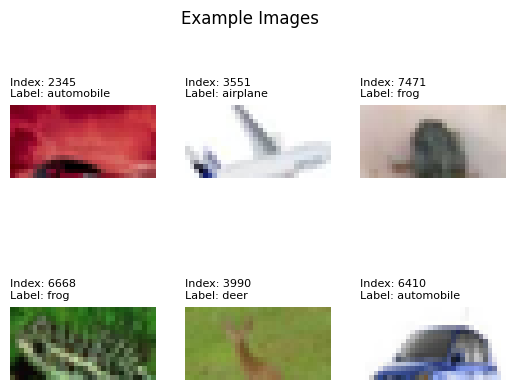

In [6]:
plot_6()

# <center>CNN Structure<center>

In [12]:

class ConvolutionalLayer:
    def __init__(self, no_of_filters=1, filter_size=3, stride=1, pad=0, input_shape=None):
        self.no_of_filters = no_of_filters
        self.filter_size = filter_size
        self.stride = stride
        self.pad = pad
        self.filters = np.random.randn(no_of_filters, filter_size, filter_size, input_shape[-1]) * 0.01 # initialise the set of filters
        self.ftmap_size = int((input_shape[0] - self.filter_size + 2*pad)/self.stride) + 1 # determine the size of output feature map
        self.input = None

    def forwardprop(self, image):
        # pad the 4 edges of the image with the provided number of pixels
        if self.pad > 0:
            image = np.pad(image, [(self.pad,self.pad), (self.pad,self.pad), (0,0)], 'constant')
        
        # store image to later backprop:
        self.input = image

        # initialise output matrix with zeros:
        output = np.zeros(shape=(self.ftmap_size, self.ftmap_size, self.no_of_filters))
        
        # (x,y) = position of the sliding window on the input image and (i,j) = updated element in the output:
        y = j = 0
        # slide the window and scan to map the outputs:
        while (y + self.filter_size) <= image.shape[1]:
            x = i = 0
            while (x + self.filter_size) <= image.shape[0]:
                window = image[x:(x+self.filter_size), y:(y+self.filter_size), :]
                # apply each filter to the defined window
                for f in range(self.no_of_filters):
                    output[i,j,f] = np.sum(self.filters[f]*window)
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return output
    
    def backprop(self, dL_dout, learn_rate):
        # initialise input gradients:
        dL_din = np.zeros(shape=(self.input.shape))
        # initialise filter gradients:
        dL_dw = np.zeros(shape=self.filters.shape)

        #convolve over input to compute gradients:
        y = j = 0
        while (y + self.filter_size) <= self.input.shape[1]:
            x = i = 0
            while (x + self.filter_size) <= self.input.shape[0]:
                window = self.input[x:(x+self.filter_size), y:(y+self.filter_size), :]
                # apply each filter to the defined window
                for f in range(self.no_of_filters):
                    dL_dw[f] += dL_dout[i,j,f] * window # each stride adds a little to the filters gradient
                    dL_din[x:(x+self.filter_size), y:(y+self.filter_size),:] +=  dL_dout[i,j,f] * self.filters[f]
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        
        #update filters:
        self.filters -= dL_dw * learn_rate
        return dL_din

class MaxPoolingLayer:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.input = None
    
    def forwardprop(self, sample):
        self.input = sample 
        ftmap_size = int((sample.shape[0] - self.pool_size)/self.stride) + 1
        output = np.zeros(shape=(ftmap_size, ftmap_size, sample.shape[-1]))

        # slide the window and scan to map the outputs:
        y = j = 0
        while (y + self.pool_size) <= sample.shape[1]:
            x = i = 0
            while (x + self.pool_size) <= sample.shape[0]:
                # pool each channel:
                for c in range(sample.shape[-1]):
                    window = sample[x:(x+self.pool_size), y:(y+self.pool_size), c]
                    output[i,j,c] = np.max(window)
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return output
    
    def backprop(self, dL_dout, learn_rate):
        dL_din = np.zeros(shape=self.input.shape) # initialise derivatives matrix

        y = j = 0
        while (y + self.pool_size) <= dL_din.shape[1]:
            x = i = 0
            while (x + self.pool_size) <= dL_din.shape[0]:
                for c in range(dL_din.shape[-1]):
                    window = self.input[x:(x+self.pool_size), y:(y+self.pool_size), c]
                    x_idx, y_idx = np.where(window == np.max(window)) # get the index of max value inside input window
                    dL_din[(x+x_idx), (y+y_idx), c] = dL_dout[i,j,c]
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return dL_din

class ActivationLayer:
    def __init__(self, fn=None, alpha = 0.001):
        self.function = fn
        self.input = None
        self.output = None
        self.alpha = alpha # for leaky relu only

    def forwardprop(self, input_arr):
        self.input = input_arr

        if self.function == 'relu':
            output = np.maximum(input_arr, 0)
        
        if self.function == 'leakyrelu':
            output = np.maximum(input_arr, self.alpha*input_arr)

        if self.function == 'sigmoid':
            output = 1/(1+np.exp(input_arr))
        
        if self.function == 'softmax':
            output = np.exp(input_arr)/np.sum(np.exp(input_arr))
        
        if self.function == None:
            output = input_arr

        self.output = output # store output to later derive
        return output
    
    def backprop(self, dL_dout, learn_rate):
        if self.function == 'relu':
            dout_din = np.int_(self.input > 0) # relu derivative
            dL_din = dL_dout * dout_din

        if self.function == 'leakyrelu':
            dout_din = np.divide(self.output, self.input, out=np.zeros_like(self.output), where=self.input!=0) # avoid divide by 0
            dL_din = dL_dout * dout_din

        if self.function == 'sigmoid':
            dout_din = self.output * (1-self.output) # sigmoid derivative
            dL_din = dL_dout * dout_din

        if self.function == 'softmax':
            output = self.output.reshape(-1,1)
            dout_din = np.diagflat(output) - np.dot(output, output.T) # derivative matrix of softmax function
            dL_din = np.dot(dout_din,dL_dout) # compute input loss deriv. by chain rule
        
        if self.function == None:
            dL_din = dL_dout
        
        return dL_din
     
class FlattenLayer:
    def __init__(self):
        self.input_shape = None
    
    def forwardprop(self, input_arr):
        self.input_shape = input_arr.shape
        return input_arr.reshape(-1,1)
    
    def backprop(self, dL_dout, learn_rate):
        return dL_dout.reshape(self.input_shape)
        
        
class DenseLayer: 
    def __init__(self, units_in, units_out, init):
        if init == 'he':
            self.weights = np.random.randn(units_out, units_in) * np.sqrt(2/units_in)
        if init == 'random':
            self.weights = np.random.randn(units_out, units_in) * 0.1

        self.biases = np.zeros(shape=(units_out,1))

    def forwardprop(self, input_arr):
        self.input = input_arr # store input for later use in backprop
        return np.dot(self.weights, input_arr) + self.biases
    
    def backprop(self, dL_dout, learn_rate):
        dL_dw = np.dot(dL_dout, self.input.T) # weight loss

        # update parameters:
        self.weights -= dL_dw * learn_rate
        self.biases -= dL_dout * learn_rate # bias loss gradient = dL_dout

        return np.dot(self.weights.T, dL_dout) # return derivative of loss wrt input, i.e. dL_din
    
class NN:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forwardpass(self, image):
        for layer in self.layers:
            image = layer.forwardprop(image)
        return image

    def backpass(self, dL_dout, learn_rate):
        for layer in reversed(self.layers):
            dL_dout = layer.backprop(dL_dout, learn_rate)

    def train(self, x_train, y_train, epochs, learn_rate):    
        from tqdm import tqdm
        y_size = np.max(y_train)+1 # vector size of one-hot encoded y
        
        for epoch in range(epochs):
            loss_sum = 0
            correct_pred = 0
            for i in tqdm(range(y_train.shape[0]), ncols = 80):
                x = x_train[i]
                y = y_train[i]
                # one hot encode y: 
                y_1hot = np.zeros(shape=(y_size,1))
                y_1hot[y] = 1
                
                # pass the image through the network to obtain the probabilities array of the image belonging in each class:
                p = self.forwardpass(x) # (1x10) shape
                
                # keep track of correct predictions:
                if np.argmax(p) == y:
                    correct_pred += 1

                # compute cross-entropy loss:
                loss_sum += -np.log(p[y,0]) # -log of probability for the correct class
                gradient = np.divide(-y_1hot,p) #derivative of cross-entropy loss function - dL_dout, (1x10) shape

                # pass the gradient back through the network to adjust weights and biases:
                self.backpass(gradient, learn_rate)
                
            print(f'Epoch: {epoch}, Loss: {loss_sum/y_train.shape[0]}, Accuracy: {correct_pred*100/y_train.shape[0]}%')
        

            
        

In [13]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

In [14]:
model = NN()

model.add(FlattenLayer())
model.add(DenseLayer(3072, 768, init='he'))
model.add(ActivationLayer('relu'))
model.add(DenseLayer(768,10, init='random')) 
model.add(ActivationLayer('softmax'))

In [15]:
model.train(x_train_scaled[:1000], y_train[:1000], epochs = 20, learn_rate=0.00035)

100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.72it/s]


Epoch: 0, Loss: 2.301678408678721, Accuracy: 18.4%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.75it/s]


Epoch: 1, Loss: 2.0029697635312944, Accuracy: 28.8%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 23.20it/s]


Epoch: 2, Loss: 1.8750617977703508, Accuracy: 33.5%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.51it/s]


Epoch: 3, Loss: 1.7834031655121239, Accuracy: 38.0%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.51it/s]


Epoch: 4, Loss: 1.7067406502758402, Accuracy: 41.3%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.47it/s]


Epoch: 5, Loss: 1.6444859902671818, Accuracy: 44.2%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.34it/s]


Epoch: 6, Loss: 1.58591574805131, Accuracy: 46.5%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.45it/s]


Epoch: 7, Loss: 1.5346323828697013, Accuracy: 48.4%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.62it/s]


Epoch: 8, Loss: 1.487212772482788, Accuracy: 50.1%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.87it/s]


Epoch: 9, Loss: 1.442972826321023, Accuracy: 52.0%


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.52it/s]


Epoch: 10, Loss: 1.4012660103232641, Accuracy: 54.0%


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.71it/s]


Epoch: 11, Loss: 1.363388936111926, Accuracy: 55.2%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.85it/s]


Epoch: 12, Loss: 1.3256322714443187, Accuracy: 57.1%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.93it/s]


Epoch: 13, Loss: 1.2916974897275304, Accuracy: 58.6%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.41it/s]


Epoch: 14, Loss: 1.258886219300587, Accuracy: 59.7%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.95it/s]


Epoch: 15, Loss: 1.2276156303617543, Accuracy: 61.1%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 23.04it/s]


Epoch: 16, Loss: 1.1976413570287425, Accuracy: 62.7%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.50it/s]


Epoch: 17, Loss: 1.1683373989812331, Accuracy: 64.5%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 23.05it/s]


Epoch: 18, Loss: 1.1400381218417244, Accuracy: 65.9%


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.35it/s]

Epoch: 19, Loss: 1.113272468182816, Accuracy: 66.6%


In [ ]:
conv = ConvolutionalLayer(no_of_filters=16,filter_size=5, stride=3, pad=3, input_shape=(32, 32, 3))
out = conv.forwardprop(x_train[1])
out

array([[[-0.114303  , -0.01146058,  0.04356634, ..., -0.02349883,
         -0.03031058, -0.04726103],
        [-0.06762716, -0.07543004, -0.0007971 , ..., -0.12010806,
         -0.13568786, -0.06738592],
        [-0.13424076, -0.04482532,  0.02740559, ..., -0.11964861,
         -0.08226063, -0.08378399],
        ...,
        [-0.03882057, -0.03516231,  0.01242676, ..., -0.06362116,
         -0.06496874, -0.0343565 ],
        [-0.04810067, -0.04221861,  0.0164314 , ..., -0.04927499,
         -0.05927476, -0.04414037],
        [ 0.01774795, -0.04269777, -0.02631166, ..., -0.06674409,
         -0.07145857, -0.0139187 ]],

       [[-0.10003841,  0.01490247, -0.06732655, ..., -0.32479236,
         -0.0356666 , -0.00777048],
        [ 0.04738127, -0.05377584, -0.03646202, ..., -0.46952117,
         -0.19024709, -0.09158121],
        [ 0.05106433, -0.05526117, -0.08070313, ..., -0.60862841,
         -0.2056032 , -0.09792662],
        ...,
        [ 0.03416682, -0.05846293, -0.01061439, ..., -

In [ ]:
relu = ActivationLayer('relu')
out = relu.forwardprop(out)
out

array([[[0.        , 0.        , 0.04356634, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.02740559, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.01242676, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.0164314 , ..., 0.        ,
         0.        , 0.        ],
        [0.01774795, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.01490247, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.04738127, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.05106433, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.03416682, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.0

In [ ]:
pool = MaxPoolingLayer()
out = pool.forwardprop(out)
out

array([[[4.73812710e-02, 1.49024745e-02, 4.35663351e-02, 0.00000000e+00,
         0.00000000e+00, 1.72251098e-01, 2.99051443e-02, 6.55776110e-02,
         2.29243945e-01, 2.17506904e-02, 2.83924211e-01, 0.00000000e+00,
         7.58914656e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.10643348e-02, 0.00000000e+00, 2.74055944e-02, 0.00000000e+00,
         0.00000000e+00, 1.71961569e-01, 5.12714623e-03, 9.11552333e-02,
         1.10589092e-01, 3.78822225e-02, 3.42133099e-01, 0.00000000e+00,
         6.56905413e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.84463882e-02, 0.00000000e+00, 4.98817824e-02, 2.22926142e-02,
         0.00000000e+00, 2.10887987e-01, 0.00000000e+00, 3.70547062e-03,
         1.36851943e-01, 4.15812372e-02, 3.28382260e-01, 0.00000000e+00,
         9.64500889e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.40305694e-01, 0.00000000e+00, 2.04585873e-02, 2.11952150e-02,
         0.00000000e+00, 1.39453813e-01, 0.00000

In [ ]:
flat = FlattenLayer()
out = flat.forwardprop(out)
out

array([[4.73812710e-02],
       [1.49024745e-02],
       [4.35663351e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.72251098e-01],
       [2.99051443e-02],
       [6.55776110e-02],
       [2.29243945e-01],
       [2.17506904e-02],
       [2.83924211e-01],
       [0.00000000e+00],
       [7.58914656e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [5.10643348e-02],
       [0.00000000e+00],
       [2.74055944e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.71961569e-01],
       [5.12714623e-03],
       [9.11552333e-02],
       [1.10589092e-01],
       [3.78822225e-02],
       [3.42133099e-01],
       [0.00000000e+00],
       [6.56905413e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.84463882e-02],
       [0.00000000e+00],
       [4.98817824e-02],
       [2.22926142e-02],
       [0.00000000e+00],
       [2.10887987e-01],
       [0.00000000e+00],
       [3.70547062e-03],


In [ ]:
den = DenseLayer(units_in=out.shape[0],units_out=10)
out = den.forwardprop(out)
out

array([[-2.92879646],
       [ 1.98206597],
       [-1.63040598],
       [ 0.86294264],
       [ 2.69760135],
       [-0.00841817],
       [-1.51684564],
       [-0.97334966],
       [-1.5038378 ],
       [ 0.47652311]])

In [ ]:
smax = ActivationLayer('softmax')
out = smax.forwardprop(out)
out

array([[0.00189964],
       [0.25788896],
       [0.00695915],
       [0.08421775],
       [0.52745548],
       [0.03523518],
       [0.00779605],
       [0.01342493],
       [0.00789812],
       [0.05722473]])

In [ ]:
y_1hot = np.zeros(shape=(10,1))
y_1hot[y_train[1]] = 1
y_1hot

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [ ]:
g = -y_1hot/out
g

array([[ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [ -0.        ],
       [-17.47496099]])

In [ ]:
g = smax.backprop(g,1)
g

array([[ 0.00189964],
       [ 0.25788896],
       [ 0.00695915],
       [ 0.08421775],
       [ 0.52745548],
       [ 0.03523518],
       [ 0.00779605],
       [ 0.01342493],
       [ 0.00789812],
       [-0.94277527]])

In [ ]:
g = den.backprop(g,1)
g

array([[ 7.42704008e-01],
       [ 5.34903590e-01],
       [-1.79369598e-01],
       [-5.28649155e-01],
       [-1.33795531e+00],
       [-3.51655680e+00],
       [ 8.50367442e-01],
       [-5.08107927e-01],
       [-8.87136777e-01],
       [ 2.62997526e-01],
       [-1.30412629e+00],
       [-1.94483267e+00],
       [-6.24961136e-01],
       [-1.04167719e+00],
       [ 6.37557096e-02],
       [ 1.38538881e+00],
       [ 1.00381387e+00],
       [ 1.14617678e+00],
       [ 1.11411944e+00],
       [ 1.63557890e+00],
       [ 3.83395265e-01],
       [ 7.12359023e-01],
       [-8.23047799e-02],
       [ 8.43301096e-01],
       [ 1.73767570e-01],
       [ 2.64309291e+00],
       [ 1.19216013e+00],
       [ 1.45065678e+00],
       [ 1.31800733e+00],
       [ 1.79318456e+00],
       [-3.44284954e-01],
       [ 2.01926232e-01],
       [ 1.75882724e+00],
       [ 5.00511542e-01],
       [ 1.06946129e+00],
       [-2.27632238e+00],
       [ 4.23948114e-01],
       [-1.71351617e+00],
       [ 7.8

In [ ]:
g = flat.backprop(g,1)
g

array([[[ 7.42704008e-01,  5.34903590e-01, -1.79369598e-01,
         -5.28649155e-01, -1.33795531e+00, -3.51655680e+00,
          8.50367442e-01, -5.08107927e-01, -8.87136777e-01,
          2.62997526e-01, -1.30412629e+00, -1.94483267e+00,
         -6.24961136e-01, -1.04167719e+00,  6.37557096e-02,
          1.38538881e+00],
        [ 1.00381387e+00,  1.14617678e+00,  1.11411944e+00,
          1.63557890e+00,  3.83395265e-01,  7.12359023e-01,
         -8.23047799e-02,  8.43301096e-01,  1.73767570e-01,
          2.64309291e+00,  1.19216013e+00,  1.45065678e+00,
          1.31800733e+00,  1.79318456e+00, -3.44284954e-01,
          2.01926232e-01],
        [ 1.75882724e+00,  5.00511542e-01,  1.06946129e+00,
         -2.27632238e+00,  4.23948114e-01, -1.71351617e+00,
          7.80950251e-01,  5.28856955e-01, -9.55915629e-01,
          1.65064791e+00, -2.59577141e+00, -4.07727283e-01,
         -6.03749723e-01, -2.21018836e-01,  1.35344165e+00,
          1.23493642e+00],
        [ 3.4190206

In [ ]:
g = pool.backprop(g,1)
g

array([[[ 0.00000000e+00,  0.00000000e+00, -1.79369598e-01, ...,
         -1.04167719e+00,  6.37557096e-02,  1.38538881e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.04167719e+00,  6.37557096e-02,  1.38538881e+00],
        [ 0.00000000e+00,  1.14617678e+00,  1.11411944e+00, ...,
          1.79318456e+00, -3.44284954e-01,  2.01926232e-01],
        ...,
        [ 0.00000000e+00, -8.49826141e-02,  0.00000000e+00, ...,
         -6.07952578e-01, -1.69326185e+00,  4.88128355e-01],
        [ 0.00000000e+00, -1.24251758e-01,  1.08056779e+00, ...,
          8.80547142e-01,  7.98957668e-04, -1.69404620e+00],
        [ 0.00000000e+00, -1.24251758e-01,  0.00000000e+00, ...,
          8.80547142e-01,  7.98957668e-04, -1.69404620e+00]],

       [[ 0.00000000e+00,  5.34903590e-01,  0.00000000e+00, ...,
         -1.04167719e+00,  6.37557096e-02,  1.38538881e+00],
        [ 7.42704008e-01,  0.00000000e+00,  0.00000000e+00, ...,
         -1.04167719e+00,  6.37557096e

In [ ]:
g = relu.backprop(g,1)
g

array([[[ 0.        ,  0.        , -0.1793696 , ..., -0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.11411944, ...,  0.        ,
         -0.        ,  0.        ],
        ...,
        [ 0.        , -0.        ,  0.        , ..., -0.        ,
         -0.        ,  0.        ],
        [ 0.        , -0.        ,  1.08056779, ...,  0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 0.        ,  0.53490359,  0.        , ..., -0.        ,
          0.        ,  0.        ],
        [ 0.74270401,  0.        ,  0.        , ..., -0.        ,
          0.        ,  0.        ],
        [ 1.00381387,  0.        ,  0.        , ...,  0.        ,
         -0.        ,  0.        ],
        ...,
        [ 0.        , -0.        ,  0.        , ..., -

In [ ]:
g.shape

(12, 12, 16)